# Dynamic Time Warping

## Files and Data
#### ground-truth folder
Contains ground truth data.


#### transcription.txt  
- XXX-YY-ZZ: XXX = Document Number, YY = Line Number, ZZ = Word Number
- Contains the character-wise transcription of the word (letters seperated with dashes)
- Special characters denoted with s_
	- numbers (s_x)
	- punctuation (s_pt, s_cm, ...)
	- strong s (s_s)
	- hyphen (s_mi)
	- semicolon (s_sq)
	- apostrophe (s_qt)
	- colon (s_qo)
    
### Task
Three files:  
##### training and test data:
train.txt, valid.txt
both contain a list of documents
##### keywords that are at least once in the training and validation set defined by train.txt and valid.txt
keywords.txt



In [1]:
import numpy as np
from matplotlib import pyplot as plt
import PIL
from dtaidistance import dtw
import cv2
import time
import os

In [2]:
IMAGES_PATH = "./word-images/"
DIRS = sorted([name for name in os.listdir(IMAGES_PATH)])

#Testing
print(DIRS)

['270', '271', '272', '273', '274', '275', '276', '277', '278', '279', '300', '301', '302', '303', '304']


In [3]:
# returns list of numpy arrays with the pixel values
def import_images():
    IMAGES_PATH = "./word-images/"
    DIRS = sorted([name for name in os.listdir(IMAGES_PATH)])
    images = list()
    id_ = 0
    for folder in DIRS:
        img_paths = IMAGES_PATH + folder
        # this sorts png files in the numerical order rather then the fancy string order
        # pls do not touch
        sorted_image_file_paths = [str(p) + ".png" for p in sorted([int(i.strip(".png")) for i in os.listdir(img_paths)])]
        for image in sorted_image_file_paths:
            images.append({ "id": id_, "document": folder, "image": cv2.imread(img_paths + "/" + image,0) })
            id_ += 1
    return images

def display_image(image):
    plt.imshow(image, interpolation='nearest', cmap='gray')
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()

In [4]:
import_images()

[{'id': 0,
  'document': '270',
  'image': array([[255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255],
         ...,
         [255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)},
 {'id': 1,
  'document': '270',
  'image': array([[255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255],
         ...,
         [255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)},
 {'id': 2,
  'document': '270',
  'image': array([[255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255],
         ...,
         [255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255],
         [255, 255, 2

In [7]:
# image size reduction

# changes grey image to binary image
def binarize(image, treshold=250):
    for index in range(len(image)):
        image[index] =  0 if image[index] < treshold else 1
    return image

# removes leading and trailing white pixels from binary image
def trim_lead_and_tail(image):
    start = -1
    end = len(image)
    index = 0
    for value in image:
        # first black value
        if start == -1 and value < 1:
            start = index -1
        # last black value
        if value < 1:
            end = index
        index += 1
    return image[start:end]

def reduce_image(image):
    # flatten array
    image = np.array(np.hstack(image))
    image = binarize(image)
    image = trim_lead_and_tail(image)
    return image

# Testing
# can only be run after image import
image = IMAGES[0]['image']
print(image)
print(image.shape)
image = reduce_image(image)
print(image)
print(image.shape)

[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]
(200, 200)
[1 0 0 ... 0 0 0]
(24375,)


In [5]:
# get the transcription of all words
def get_file(filepath):
    lines = list()
    with open(filepath, 'r') as f:
        lines = f.read().splitlines()
    return lines

# unpacks a row from the transcript, return a dict with the corresponding values
def parse_transcript_row(row):
    metadata, word = row.split(" ")
    document, line, col = metadata.split("-")
    # special_char = ""
    # if "_" in word:
    #   word, special_chars = word.split("_")
    return {"document": document, "line": line, "col": col, "word": word}

# Testing
parse_transcript_row("274-20-02 C-a-t-t-l-e-s_cm")

# parse all words to usable dict
def parse_transcript(transcript):
    data = dict()
    id_counter = 0
    for row in transcript:
        data[id_counter] = parse_transcript_row(row)
        id_counter += 1
    return data

# finds an entry in the transcript based on the word, returns all found entries ids
def find_by_word(transcript, word):
    ids = list()
    for id_, item in transcript.items():
        if item['word'] == word:
            ids.append(id_)
    return ids

# Testing
transcript = np.array(["275-07-09 r-e-m-a-r-k-a-b-l-y",
                      "275-08-01 a-w-k-w-a-r-d-s_cm", "275-08-02 p-a-r-t-i-c-u-l-a-r"])
transcript = parse_transcript(transcript)
print(transcript)

print(find_by_word(transcript, "a-w-k-w-a-r-d-s_cm"))

{0: {'document': '275', 'line': '07', 'col': '09', 'word': 'r-e-m-a-r-k-a-b-l-y'}, 1: {'document': '275', 'line': '08', 'col': '01', 'word': 'a-w-k-w-a-r-d-s_cm'}, 2: {'document': '275', 'line': '08', 'col': '02', 'word': 'p-a-r-t-i-c-u-l-a-r'}}
[1]


{'document': '273', 'line': '23', 'col': '05', 'word': 'A-l-e-x-a-n-d-r-i-a'}


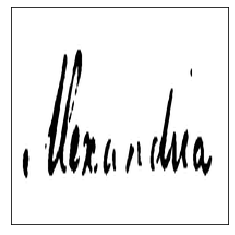

In [8]:
# files where keywords for validation are located
VALID_DOCUMENT_IDS = get_file('valid.txt')
# files where keywords for training are located
TRAIN_DOCUMENT_IDS = get_file('train.txt')
# list of words which are present in the training set and also in the valid set
KEYWORDS = get_file('keywords.txt')
# dict of images with pages and image as np array
IMAGES = import_images()

transcript_list = get_file('ground-truth/transcription.txt')
# final transcript with all infos about words
TRANSCRIPT = parse_transcript(transcript_list)

## the id for IMAGES corresponds to the word in TRANSCRIPT. so IMAGES[1] is the word in TRANSCRIPT[1]

print(TRANSCRIPT[872])
display_image(IMAGES[872]['image'])


In [9]:
# sums up each column of the given image, returns the feature vector
# used for sliding window procedure
def compress_to_feature_vector(image):
    # initialize to number of columns in image
    feature_vector = np.zeros(image.shape[1], dtype=float)
    for row in image:
        col_nb = 0
        for col_value in row:
            feature_vector[col_nb] = feature_vector[col_nb] + col_value
            col_nb += 1
    return feature_vector

# same as function above, but counts black pixels instead of summing up the values
def compress_to_feature_vector_binary(image):
    # initialize to number of columns in image
    feature_vector = np.zeros(image.shape[1], dtype=float)
    for row in image:
        col_nb = 0
        for col_value in row:
            # if this pixel is not white
            if col_value < 255:
                feature_vector[col_nb] += 1
            col_nb += 1
    return feature_vector

print(IMAGES[0]['image'])
test = IMAGES[0]['image']
result = compress_to_feature_vector_binary(test)
print(result)

[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]
[  0.   0.   0.   0.   0.   0.  19.  10.  34.  37.  48.  55.  61.  66.
  68.  70.  66.  70.  76.  81.  81.  84.  83.  85.  86.  90.  92.  97.
  96.  97. 102.  99.  98.  98.  98.  94.  97. 100. 100.  99.  98.  94.
  92.  89.  83.  77.  65.  61.  48.  43.  33.  28.  24.  13.  14.   0.
   0.   0.   0.   0.   0.   8.  16.  17.  31.  33.  40.  44.  54.  60.
  66.  70.  70.  73.  73.  78.  76.  73.  72.  70.  67.  60.  59.  63.
  64.  66.  69.  65.  66.  63.  60.  61.  53.  48.  47.  44.  50.  50.
  47.  50.  62.  65.  71.  77.  78.  79.  80.  80.  80.  77.  78.  75.
  71.  70.  65.  62.  63.  62.  64.  66.  66.  65.  69.  66.  67.  70.
  68.  72.  68.  72.  72.  69.  72.  78.  80.  85.  85.  82.  81.  76.
  73.  69.  61.  52.  48.  34.  23.  13.  15.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.  

In [10]:
# get all images in feature vector form, keep the dictionary shape
IMAGES_FEATURES = IMAGES
for image in IMAGES_FEATURES:
    image['image'] = compress_to_feature_vector_binary(image['image'])

print(IMAGES_FEATURES[0]['image'])

[  0.   0.   0.   0.   0.   0.  19.  10.  34.  37.  48.  55.  61.  66.
  68.  70.  66.  70.  76.  81.  81.  84.  83.  85.  86.  90.  92.  97.
  96.  97. 102.  99.  98.  98.  98.  94.  97. 100. 100.  99.  98.  94.
  92.  89.  83.  77.  65.  61.  48.  43.  33.  28.  24.  13.  14.   0.
   0.   0.   0.   0.   0.   8.  16.  17.  31.  33.  40.  44.  54.  60.
  66.  70.  70.  73.  73.  78.  76.  73.  72.  70.  67.  60.  59.  63.
  64.  66.  69.  65.  66.  63.  60.  61.  53.  48.  47.  44.  50.  50.
  47.  50.  62.  65.  71.  77.  78.  79.  80.  80.  80.  77.  78.  75.
  71.  70.  65.  62.  63.  62.  64.  66.  66.  65.  69.  66.  67.  70.
  68.  72.  68.  72.  72.  69.  72.  78.  80.  85.  85.  82.  81.  76.
  73.  69.  61.  52.  48.  34.  23.  13.  15.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0. 

In [12]:
## Reduce images to flat, binary, trimmed array
## will probably not be used as it is very inefficient
# IMAGES_REDUCED = IMAGES
# for image in IMAGES_REDUCED:
#     image['image'] = reduce_image(image['image']) 

In [11]:
# save dictionary with images and load it again
import pickle

def save_obj(obj, name ):
    with open('obj/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)
    


## Testing

### Evaluation

##### Feature Vectors
We used sliding window with 1px window width and 1px offset.  
Used vectors: 
1. number of black pixels per window

##### Questions (2)
*1. How many selected items are relevant?*  
*2. How many of the relevant are selected?*  
Precision = TP / TP + FP; Recall = TP / TP + FN  
WHERE TP: True positive, FP: False positive, FN: False negative


#### Steps
- iterate keywords
- for each keyword, find all other keywords
- for all other found keywords check if they are correct




In [12]:
########## IMPORT everyhting if not done already
# files where keywords for validation are located
VALID_DOCUMENT_IDS = get_file('valid.txt')
# files where keywords for training are located
TRAIN_DOCUMENT_IDS = get_file('train.txt')
# list of words which are present in the training set and also in the valid set
KEYWORDS = get_file('keywords.txt')
# dict of images with pages and image as np array
IMAGES = import_images()
transcript_list = get_file('ground-truth/transcription.txt')
# final transcript with all infos about words
TRANSCRIPT = parse_transcript(transcript_list)

In [ ]:
######### EXCRACT feature vector (1)
# get all images in feature vector form, keep the dictionary shape
# IMAGES_FEATURES = IMAGES
# for image in IMAGES_FEATURES:
#    image['image'] = compress_to_feature_vector_binary(image['image'])


In [24]:
# run dtw with new compressed feature vectors (sliding window)
start = time.time()
series = np.array([image['image'] for image in IMAGES_FEATURES if image['document'] in TRAIN_DOCUMENT_IDS])
end = time.time()

print(len(series[0]))
print(TRAIN_DOCUMENT_IDS)
print(IMAGES_FEATURES[0]['document'])

print("import: " + str(end - start))
from dtaidistance import dtw

start = time.time()
ds = dtw.distance_matrix_fast(series)
end = time.time()
print(ds)


print("took: " + str(end - start) + " for " + str(len(series)) + " elements")

mat = np.matrix(ds)
print(mat)
mat.dump("distance_matrix.dat")
mat2 = np.load("distance_matrix.dat", allow_pickle = True)
print(mat2)

200
['270', '271', '272', '273', '274', '275', '276', '277', '278', '279']
270
import: 0.004003286361694336
[[         inf 109.74515935 168.97041161 ... 206.92752354 157.39440905
  172.22949805]
 [         inf          inf 140.16418944 ... 142.01056299 126.93305322
   95.77577982]
 [         inf          inf          inf ... 153.60989551 122.99593489
  142.92655457]
 ...
 [         inf          inf          inf ...          inf  97.66268479
  136.27178725]
 [         inf          inf          inf ...          inf          inf
   93.37558567]
 [         inf          inf          inf ...          inf          inf
           inf]]
took: 41.68380379676819for 2433 elements
[[         inf 109.74515935 168.97041161 ... 206.92752354 157.39440905
  172.22949805]
 [         inf          inf 140.16418944 ... 142.01056299 126.93305322
   95.77577982]
 [         inf          inf          inf ... 153.60989551 122.99593489
  142.92655457]
 ...
 [         inf          inf          inf ...          inf

2433
2433


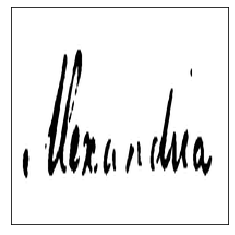

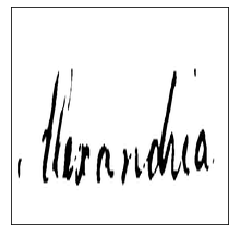

78.22403722641782


In [45]:
print(len(series))
print(len(ds))
display_image(IMAGES[872]['image'])
display_image(IMAGES[2007]['image'])
print(ds[872][2007])
# print(ds[872][2485])
# print(ds[872][3531])
# print(ds[2007][2485])
# print(ds[2007][3531])
# print(ds[2485][3531])
THRESHOLD = 80

A-l-e-x-a-n-d-r-i-a
{'document': '270', 'line': '05', 'col': '01', 'word': 'd-o-w-n'}
[872, 2007, 2485, 3531]
[872, 2007]
[2007]


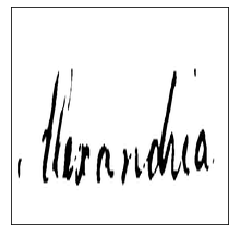

In [46]:
print(KEYWORDS[0])
print(TRANSCRIPT[23])

# finds an entry in the transcript based on the word, returns all found entries ids
def findall_by_word(transcript, word):
    ids = list()
    for id_, item in transcript.items():
        if word in item['word']:
            ids.append(id_)
    return ids

# Testing
# transcript = np.array(["275-07-09 r-e-m-a-r-k-a-b-l-y",
#                     "275-08-01 a-w-k-w-a-r-d-s_cm", "275-08-02 p-a-r-t-i-c-u-l-a-r"])
# transcript = parse_transcript(transcript)
# print(transcript)

ids = findall_by_word(TRANSCRIPT, KEYWORDS[0])
print(ids) #the words in the training dataset at this index should be the true positives
# display_image(IMAGES[872]['image'])
# display_image(IMAGES[2007]['image'])
# display_image(IMAGES[2485]['image'])
# display_image(IMAGES[3531]['image'])
ids = [i for i in ids if i <= len(ds)]
print(ids)

# TODO: get all rows of the matrix (according to ids) and extract all words, which distance is lower than THRESHOLD
matches = list()
for col in range(len(ds)):
    if ds[ids[0]][col] < THRESHOLD:
        matches.append(col)
print(matches)
for m in range(len(matches)):
    display_image(IMAGES[matches[m]]['image'])


In [41]:
# run dtw with new compressed feature vectors (sliding window)
# testing with 2x the word alexandria
start = time.time()
series = [
    np.array(IMAGES_FEATURES[872]['image'], dtype=float),
    np.array(IMAGES_FEATURES[2007]['image'], dtype=float)
]
end = time.time()

print(len(series[0]))

print("import: " + str(end - start))
from dtaidistance import dtw

start = time.time()
ds = dtw.distance_matrix_fast(series)
end = time.time()
print(ds)


print("took: " + str(end - start) + "for " + str(len(series)) + " elements")

200
import: 0.00040149688720703125
(1, 1)
[[        inf 78.22403723]
 [        inf         inf]]
took: 0.0033066272735595703for 2 elements


[872, 2007]
[{'word': 'A-l-e-x-a-n-d-r-i-a', 'line': '23', 'document': '273', 'col': '05'}]


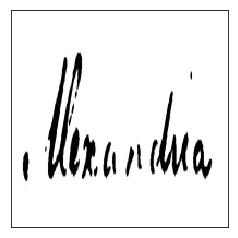

In [11]:
# example usage for find_by_word
ids_ = find_by_word(TRANSCRIPT, 'A-l-e-x-a-n-d-r-i-a')
print(ids_)

print([TRANSCRIPT[ids_[0]]])
display_image(IMAGES[ids_[0]]['image'])



In [6]:
load_obj("images_featuressss")

FileNotFoundError: [Errno 2] No such file or directory: 'obj/images_featuressss.pkl'

In [13]:
np.array([])

array([], dtype=float64)

In [ ]:
# distance calculation test for 20 images compared to image 0
image1 = IMAGES[0]['image']
images = [image['image'] for image in IMAGES[1:20]]
print(image1)
print(images[0])

import time
from dtaidistance import dtw
import dtaidistance
image1 = np.array(image1, dtype=np.double)
start = time.time()
for image in images:
    print(image)
    distance = dtw.distance_fast(image1, np.array(image, dtype=np.double), max_dist=4000,)
    print(distance)
end = time.time()
print("took: " + str(round(end - start, 2)) + " seconds")
    

In [26]:
# distance calculation test for 20 images compared to image 0 with Images reduced
image1 = IMAGES_REDUCED[0]['image']
images = [image['image'] for image in IMAGES_REDUCED[1:20]]
print(image1)
print(images[0])

import time
from dtaidistance import dtw
import dtaidistance
image1 = np.array(image1, dtype=np.double)
start = time.time()
for image in images:
    distance = dtw.distance_fast(image1, np.array(image, dtype=np.double), max_dist=4000,)
    print(distance)
end = time.time()
print("took: " + str(round(end - start, 2)) + " seconds")
    

[1 0 0 ... 0 0 0]
[1 0 0 ... 1 1 1]
[1 0 0 ... 1 1 1]
18.65475810617763
[1 0 1 ... 1 1 0]
13.341664064126334
[1 0 0 ... 1 1 1]
13.490737563232042
[1 0 1 ... 1 1 1]
44.94441010848846
[1 0 0 ... 0 0 0]
15.7797338380595
[1 0 0 ... 0 0 0]
1.4142135623730951
[1 0 0 ... 0 0 0]
17.97220075561143
[1 0 0 ... 1 1 1]
20.8806130178211
[1 0 1 ... 1 1 1]
20.29778313018444
[1 0 0 ... 1 0 0]
16.822603841260722
[1 0 0 ... 1 0 0]
33.60059523282288
[1 0 0 ... 1 1 1]
18.05547008526779
[1 0 0 ... 1 1 1]
27.23967694375247
[1 0 0 ... 1 1 1]
24.899799195977465
[1 0 1 ... 0 0 0]
11.045361017187261
[1 0 0 ... 1 1 1]
11.045361017187261
[1 0 0 ... 1 0 0]
16.217274740226856
[1 0 0 ... 0 0 0]
30.59411708155671
[1 0 1 ... 1 1 0]
13.152946437965905
took: 49.11 seconds


In [44]:
### Testing of dtaidistance https://dtaidistance.readthedocs.io/en/latest/usage/installation.html

from dtaidistance import dtw
import time

result = dtw.try_import_c()
print(result)

image1 = np.array(IMAGES_REDUCED[0]['image'], dtype=np.float)
image2 = np.array(IMAGES_REDUCED[1]['image'], dtype=np.float)

start = time.time()
distance = dtw.distance_fast(image1, image2)
end = time.time()
print(distance)
print("took: " + str(end - start))

None
18.65475810617763
took: 3.67526912689209


In [28]:
### Testing of dtw https://github.com/pierre-rouanet/dtw

import numpy as np

# We define two sequences x, y as numpy array
# where y is actually a sub-sequence from x
x = np.array([2, 0, 1, 1, 2, 4, 2, 1, 2, 0]).reshape(-1, 1)
y = np.array([1, 1, 2, 4, 2, 1, 2, 0]).reshape(-1, 1)

from dtw import dtw


manhattan_distance = lambda x, y: np.abs(x - y)

result = dtw(x, y)

print(result)

# You can also visualise the accumulated cost and the shortest path



TypeError: dtw() missing 1 required positional argument: 'dist'

In [29]:
### Testing of dtw-python library https://dynamictimewarping.github.io/py-api/html/

import dtw
import numpy as np

print(np.concatenate(IMAGES[0]['image']))
query = np.concatenate(IMAGES[0]['image'])

## A cosine is for template; sin and cos are offset by 25 samples
template = np.concatenate(IMAGES[1]['image'])

## Find the best match with the canonical recursion formula
from dtw import *
alignment = dtw(query, template, window_type="sakoechiba")

## Display the warping curve, i.e. the alignment curve
alignment.plot(type="threeway")

## Align and plot with the Rabiner-Juang type VI-c unsmoothed recursion
#dtw(query, template, 
#    step_pattern=rabinerJuangStepPattern(6, "c"))\
#    .plot(type="twoway",offset=-2)

## See the recursion relation, as formula and diagram
#print(rabinerJuangStepPattern(6,"c"))
#rabinerJuangStepPattern(6,"c").plot()

## And much more!


ValueError: zero-dimensional arrays cannot be concatenated

In [46]:
series = [
    np.array(IMAGES_REDUCED[0]['image'], dtype=np.float),
    np.array(IMAGES_REDUCED[1]['image'], dtype=np.float),
    np.array(IMAGES_REDUCED[2]['image'], dtype=np.float),
    np.array(IMAGES_REDUCED[3]['image'], dtype=np.float),
    np.array(IMAGES_REDUCED[4]['image'], dtype=np.float),
    np.array(IMAGES_REDUCED[5]['image'], dtype=np.float),
    np.array(IMAGES_REDUCED[6]['image'], dtype=np.float),
    np.array(IMAGES_REDUCED[7]['image'], dtype=np.float),
    np.array(IMAGES_REDUCED[8]['image'], dtype=np.float),
    np.array(IMAGES_REDUCED[9]['image'], dtype=np.float),
    np.array(IMAGES_REDUCED[10]['image'], dtype=np.float),
    np.array(IMAGES_REDUCED[11]['image'], dtype=np.float),
    np.array(IMAGES_REDUCED[12]['image'], dtype=np.float),
    np.array(IMAGES_REDUCED[13]['image'], dtype=np.float),
    np.array(IMAGES_REDUCED[14]['image'], dtype=np.float),
    np.array(IMAGES_REDUCED[15]['image'], dtype=np.float),
    np.array(IMAGES_REDUCED[16]['image'], dtype=np.float),
    np.array(IMAGES_REDUCED[17]['image'], dtype=np.float),
    np.array(IMAGES_REDUCED[18]['image'], dtype=np.float),
    np.array(IMAGES_REDUCED[19]['image'], dtype=np.float),
    np.array(IMAGES_REDUCED[20]['image'], dtype=np.float),
]

start = time.time()
ds = dtw.distance_matrix_fast(series)
end = time.time()
print(ds)


print("took: " + str(end - start))

(210, 210)
[[        inf 18.65475811 13.34166406 13.49073756 44.94441011 15.77973384
   1.41421356 17.97220076 20.88061302 20.29778313 16.82260384 33.60059523
  18.05547009 27.23967694 24.8997992  11.04536102 11.04536102 16.21727474
  30.59411708 13.15294644 23.89560629]
 [        inf         inf 12.9614814  28.23118843 28.01785145 10.04987562
  18.76166304 38.92300091 42.63801121 42.07136794 36.02776707 51.60426339
  38.88444419 47.70744177 46.06517123 24.10394159 23.83275058 34.6121366
  49.8998998  27.82085549 45.32107677]
 [        inf         inf         inf 20.14944168 36.138622    8.42614977
  13.41640786 32.52691193 37.         36.29049462 28.7923601  47.73887305
  32.54228019 43.11612227 41.29164564 17.32050808 17.2626765  27.
  45.59605246 19.74841766 40.42276586]
 [        inf         inf         inf         inf 52.57375771 22.89104628
  13.49073756 12.12435565 13.96424004 13.67479433 10.29563014 23.3023604
  12.         18.05547009 16.52271164  7.81024968  7.74596669  9.273

In [47]:
# store the output of the calcuated matrix for images 1 to 20 in case the code is rerun
save = ds
print(ds)

[[        inf 18.65475811 13.34166406 13.49073756 44.94441011 15.77973384
   1.41421356 17.97220076 20.88061302 20.29778313 16.82260384 33.60059523
  18.05547009 27.23967694 24.8997992  11.04536102 11.04536102 16.21727474
  30.59411708 13.15294644 23.89560629]
 [        inf         inf 12.9614814  28.23118843 28.01785145 10.04987562
  18.76166304 38.92300091 42.63801121 42.07136794 36.02776707 51.60426339
  38.88444419 47.70744177 46.06517123 24.10394159 23.83275058 34.6121366
  49.8998998  27.82085549 45.32107677]
 [        inf         inf         inf 20.14944168 36.138622    8.42614977
  13.41640786 32.52691193 37.         36.29049462 28.7923601  47.73887305
  32.54228019 43.11612227 41.29164564 17.32050808 17.2626765  27.
  45.59605246 19.74841766 40.42276586]
 [        inf         inf         inf         inf 52.57375771 22.89104628
  13.49073756 12.12435565 13.96424004 13.67479433 10.29563014 23.3023604
  12.         18.05547009 16.52271164  7.81024968  7.74596669  9.2736185
  20.8

### **dtaidistance:** fancy pantsy library for DTW
##### Installation:
`pip install dtaidistance`  
**github:** [github-repo for dtaidistance](https://github.com/wannesm/dtaidistance)

(<Figure size 720x720 with 4 Axes>,
  <matplotlib.axes._subplots.AxesSubplot at 0x7f39c2e9bdd0>])

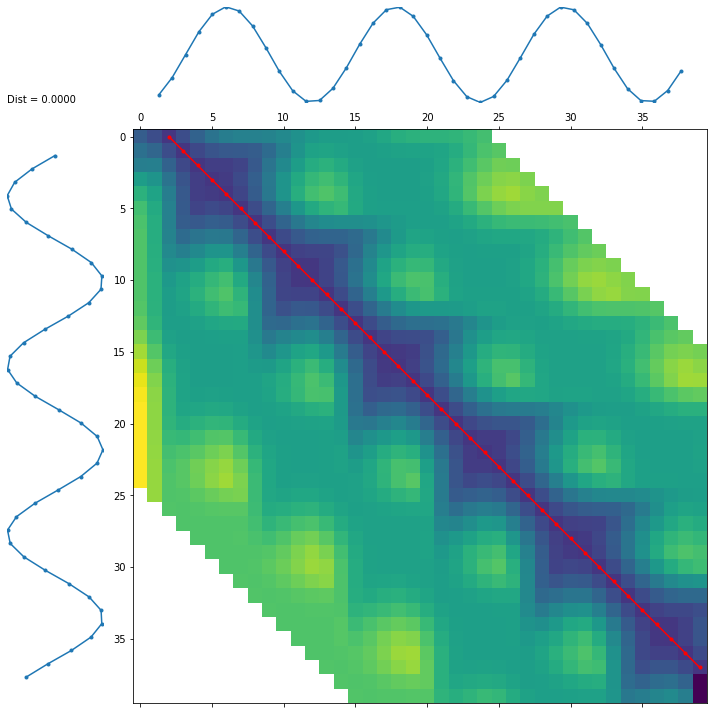

In [32]:
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
import numpy as np
x = np.arange(0, 20, .5)
s1 = np.sin(x)
s2 = np.sin(x - 1)
d, paths = dtw.warping_paths(s1, s2, window=25, psi=2)
best_path = dtw.best_path(paths)
dtwvis.plot_warpingpaths(s1, s2, paths, best_path)


In [31]:
image1 = np.array(np.concatenate(IMAGES[0]['image']), dtype=np.float)
image2 = np.array(np.concatenate(IMAGES[19]['image']), dtype=np.float)
#print(IMAGES[872])
#print(IMAGES[2007])

display_image(IMAGES[1]['image'])
display_image(IMAGES[19]['image'])
distance = dtw.distance_fast(image1, image2)
print(distance)

image1 = np.array(np.concatenate(IMAGES[872]['image']), dtype=np.float)
image2 = np.array(np.concatenate(IMAGES[2007]['image']), dtype=np.float)
#print(IMAGES[872])
#print(IMAGES[2007])

display_image(IMAGES[872]['image'])
display_image(IMAGES[2007]['image'])
distance = dtw.distance_fast(image1, image2)
print(distance)


ValueError: zero-dimensional arrays cannot be concatenated

In [ ]:
from dtaidistance import dtw

result = dtw.try_import_c()
print(result)

### DTW required steps
- [ ] initialize matrix
- [ ] calculate each field in the matrix
- [ ] find the shortest path from 0,0 to i,j through the matrix by iterating and increasing either i, j or both
##### Efficiency
- [ ] only calculate matrix fields within a certain treshold (Sakoe-Chiba Band)

In [ ]:
### Custom DTW
def dtw(s, t):
    n, m = len(s), len(t)
    dtw_matrix = np.zeros((n+1, m+1))
    for i in range(n+1):
        for j in range(m+1):
            dtw_matrix[i, j] = np.inf
    dtw_matrix[0, 0] = 0
    
    for i in range(1, n+1):
        for j in range(1, m+1):
            cost = abs(s[i-1] - t[j-1])
            # take last min from a square box
            last_min = np.min([dtw_matrix[i-1, j], dtw_matrix[i, j-1], dtw_matrix[i-1, j-1]])
            dtw_matrix[i, j] = cost + last_min
    return dtw_matrix

In [ ]:
from PIL import Image
images = import_images()
print(len(images[0]))

# result = dtw([1,2,3], [2,2,2,2,3,4])
# print("result: " + str(result))
display_image(images[0])


#### Steps for the task
- get all images
- convert each image to a numpy array with dtype np.double

In [ ]:
from PIL import Image
import numpy as np

images = import_images()

print(np.asarray(images[0]))

display_image(images[0])